<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-and-preparing-data" data-toc-modified-id="Loading-and-preparing-data-1">Loading and preparing data</a></span><ul class="toc-item"><li><span><a href="#Intermediate-conclusion" data-toc-modified-id="Intermediate-conclusion-1.1">Intermediate conclusion</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.2">Conclusion</a></span></li></ul></li><li><span><a href="#Model-training-and-validation" data-toc-modified-id="Model-training-and-validation-2">Model training and validation</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.1">Conclusion</a></span></li></ul></li><li><span><a href="#Preparing-for-Profit-Calculation" data-toc-modified-id="Preparing-for-Profit-Calculation-3">Preparing for Profit Calculation</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.1">Conclusion</a></span></li></ul></li><li><span><a href="#Calculation-of-profit-and-risks" data-toc-modified-id="Calculation-of-profit-and-risks-4">Calculation of profit and risks</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li></ul></div>

# Well location selection

It is necessary to decide where to drill a new well for the production company

We were provided with oil samples in three regions: in each - 10,000 fields, where we measured the quality of oil and the volume of its reserves. A machine learning model must be built to help determine the region where mining will bring the most significant profit. Analysis of possible gains and risks should be done using the *Bootstrap.* technique.

Steps to choose a location:

- In the selected region, a deposit is searched, and for each, the values of the features are determined;
- Building a model and assessing the volume of reserves;
- Search for the deposit with the highest value score. The number of fields depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected deposits.

## Loading and preparing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from itertools import product
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')
geo_df = [geo_data_0, geo_data_1, geo_data_2]

line = '==='
i=1
for data in geo_df:
    print(f'{line*21}\nRegion {i}:\n{line*21}')
    display(data.sample(5), data.shape)
    i+=1

Region 1:


,id,f0,f1,f2,product
29307,93bOM,0.562396,0.626770,1.925240,151.112329
63906,3904N,0.425611,1.076738,2.916254,122.669563
30010,lEZnM,1.303804,-0.205332,0.410010,29.911323
99432,a6VQQ,1.600667,-0.617557,1.566949,110.215652
17910,Wfc3f,0.422571,-0.299100,4.827240,181.396631


(100000, 5)

Region 2:


,id,f0,f1,f2,product
30337,z2LYW,-9.195483,-2.312563,1.998036,57.085625
48005,qLfU7,12.446606,-7.130318,3.997416,107.813044
65919,c26cG,-0.564195,-3.976619,1.991902,57.085625
72035,FhJj3,-6.014947,-4.519604,3.012383,84.038886
18174,x57GE,15.615783,-5.859162,1.005386,26.953261


(100000, 5)

Region 3:


,id,f0,f1,f2,product
29895,WfebS,3.032842,-1.277652,4.373396,119.935318
43388,iRj1Y,1.178283,-1.188841,6.465481,97.401235
55125,TFPxR,2.131819,-1.057503,4.317005,42.257491
23234,LpxQW,1.020714,-0.482484,1.010306,141.414010
12807,N45jh,-5.169341,0.530403,-2.655512,68.038678


(100000, 5)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
We were provided with historical data for three regions where 100,000 wells were found. Each well was assigned an <code>id</code> number. For each of the wells, calculations were made of the parameters that affect the quality and quantity of oil in it. The last <code>product</code> column shows the actual amount of inventory.
    
It is necessary to evaluate all the received data as a whole. To do this, we construct histograms for each region.

</div>

Loading: 0it [00:00, ?it/s]

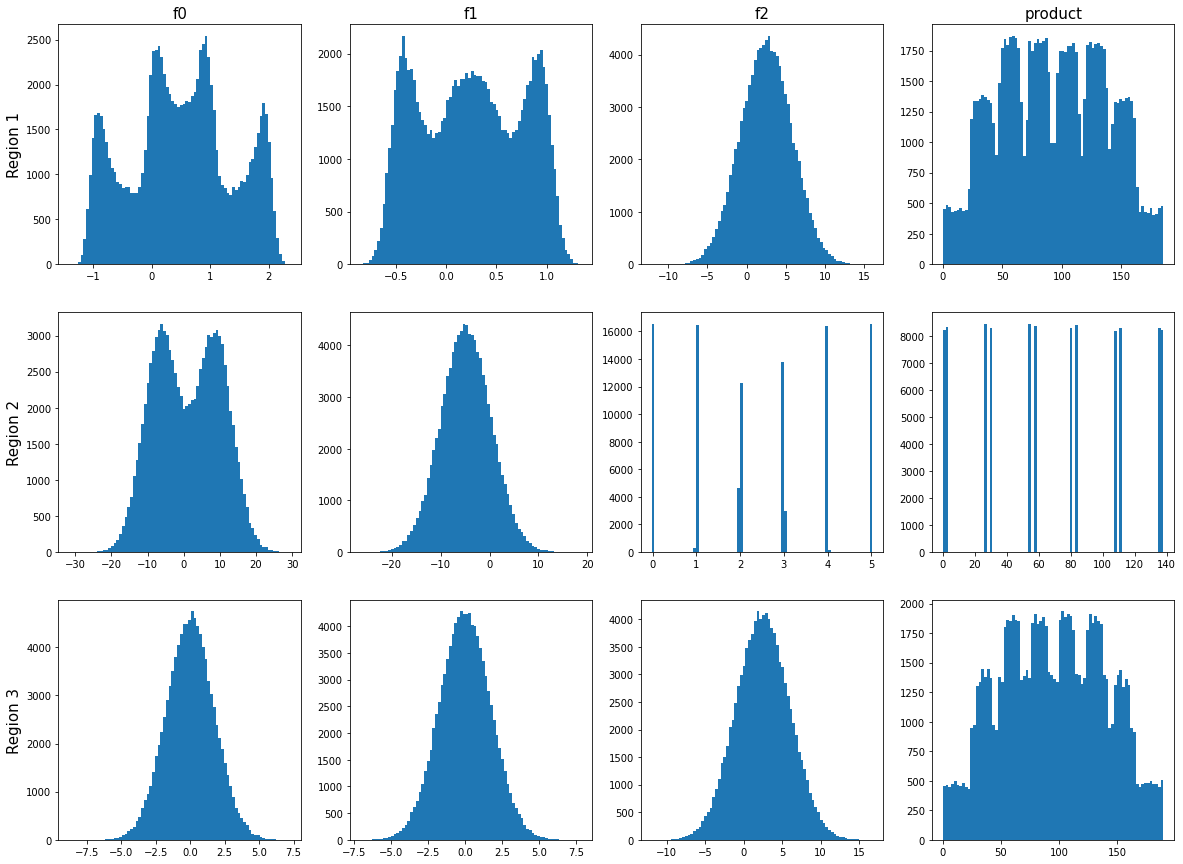

In [3]:
fig, ax = plt.subplots(3, 4,figsize = (20,15))
y = np.arange(0,3) 
x = np.arange(0,4) 
geo_name = ['Region 1', 'Region 2', 'Region 3']
columns = ['f0', 'f1', 'f2', 'product']
coord = product(x,y)

for i in tqdm(coord, desc = 'Loading'):
    ax[i[1]][i[0]].hist(geo_df[i[1]][columns[i[0]]], bins=80)
for row in y:
    ax[row][0].set_ylabel(geo_name[row], fontsize = 15)
for column in x:
    ax[0][column].set_title(columns[column], fontsize = 15)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Intermediate conclusion

As can be seen from the histograms, we are dealing with different types of regions. In some areas, the qualitative parameters have the form of a normal distribution, somewhere they take strict values ​​and have approximately equal probability, and somewhere they look like casts 👻
    
At this stage, with a small degree of probability, it can be assumed that the <code>f2</code> parameter most of all affects the distribution of reserves in wells because the parameters <code>f0</code> and <code>f1</code> are different for regions 1 and 3. In contrast, the parameters <code>f2</code> and the target feature <code>product</code> have the same look.
    
It can also be assumed that after training, the model will more accurately predict the target feature for the second region, in which the amount of oil does not have such a large number of values, and there is a sufficiently large distance between them.
    
In this problem, we are not interested in the nature of the parameters f have, so we will study the data for repetitions and gaps and not check for noise.

</div>

In [4]:
alldata = pd.concat([geo_data_0, geo_data_1, geo_data_2])
print('Number of duplicates in all tables:', alldata.duplicated().sum())
print('Number of duplicate well ids in all tables:', alldata['id'].duplicated().sum())

i=1
for data in geo_df:
    print(f'Number of duplicate well ids in the Region {i}:', data['id'].duplicated().sum())
    i+=1

Number of duplicates in all tables: 0
Number of duplicate well ids in all tables: 49
Number of duplicate well ids in the Region 1: 10
Number of duplicate well ids in the Region 2: 4
Number of duplicate well ids in the Region 3: 4


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    

No complete duplicates were found between all regions, meaning the areas do not intersect, and the samples are not pairwise interconnected.
    
However, there are duplicates in the wells' <code>id</code>. There may be two reasons:
    
1. Errors when assigning <code>id</code> to each well. This does not affect further calculations;
2. The data were obtained at different times. During this time difference, oil could start to be produced from the well, or even deeper / wider could be drilled. In this case, the data were enriched with new parameters, and this, on the contrary, has a positive effect on further calculations.
    
Remove this column and check gaps and data types.

</div>

In [5]:
i=1
for data in geo_df:
    print(f'{line*21}\nRegion {i}:\n{line*21}')
    display(data.describe(), data.info())
    i+=1

Region 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


None

Region 2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


None

Region 3:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


None

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Conclusion
    
We were provided data for three regions where 100,000 wells were found. Each well was assigned an <code>id</code> number. For each of the wells, calculations were made of the parameters that affect the quality and quantity of oil in it. The last <code>product</code> column shows the actual amount of inventory.
    
As can be seen from the histograms, we are dealing with different types of regions. Somewhere in the areas, the qualitative parameters have the form of a normal distribution; somewhere, they take strict values and have approximately equal probability.
    
No complete duplicates were found between all regions, which means that the areas do not intersect with each other, and the samples are not pairwise interconnected.
    
No gaps were found, and the data types are suitable for training and validating our model.
    
Judging by the values of the target attribute <code>product</code>, we are faced with the task of regression. Best of all, the Linear Regression model will cope with this in the task context. We need to write a function that:
    
- Split data into features (<code>f0</code>,<code>f1</code> and <code>f2</code>) and targets (<code>product</code>) for each region
- Will scale features
- Will split our data into samples: Training and Validation (test) in the ratio 75/25;
- Train our Linear Regression on the training set
- Displays two metrics: Mean of predicted <code>product</code> in expected and Root Mean Square Error of our predictions (RMSE)
- Writes all indicators of predictions and the actual amount of <code>product</code> into separate variables to help us further predict the amount of oil in new regions, test our predictions, and calculate risks.

</div>

## Model training and validation

In [6]:
random_state = 12345
def split_and_train(data):
    # Setting up features and targets
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    
    # Scaling
    scaler = StandardScaler()
    scaler.fit(features)
    features = scaler.transform(features)
    
    # Labeling data into training and validation sets
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=random_state)
    # Train Linear Regression
    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    
    # Making predictions on validation features (verification)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    
    # RMS error
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    
    # Average prediction for a region
    average_product = sum(predictions) / len(predictions)
    
    # Returning our predictions, targets
    return (predictions, target_valid.reset_index(drop=True), rmse)



,region,predicted_μ_product,valid_μ_product,RMSE
0,Region 1,92592,92078.596741,37.58
1,Region 2,68728,68723.136024,0.89
2,Region 3,94965,94884.232809,40.03


Region 1:


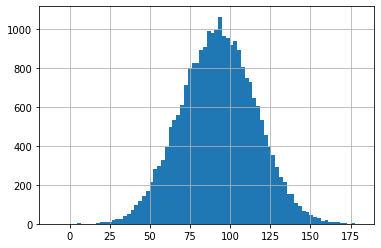

Region 2:


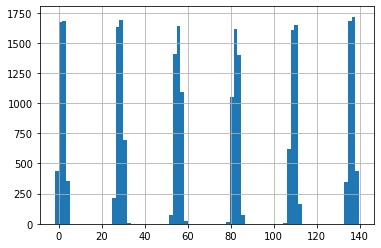

Region 3:


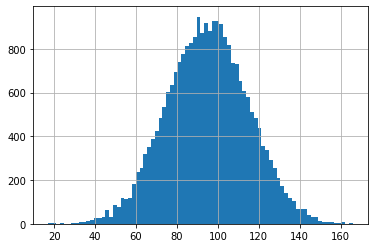

In [7]:
# Write down our predictions, validation, and standard error for each region
predict_prod_0, valid_prod_0, rmse_0 = split_and_train(geo_data_0)
predict_prod_1, valid_prod_1, rmse_1 = split_and_train(geo_data_1)
predict_prod_2, valid_prod_2, rmse_2 = split_and_train(geo_data_2)

# List of average predictions for a region
predict_prod = [int(sum(predict_prod_0)*1000 / len(predict_prod_0)),
                int(sum(predict_prod_1)*1000 / len(predict_prod_1)),
                int(sum(predict_prod_2)*1000 / len(predict_prod_2))]
# List of average actual value
valid_prod = [valid_prod_0.mean()*1000,
              valid_prod_1.mean()*1000,
              valid_prod_2.mean()*1000]
# List of root mean square errors for a region
rmse = [round(rmse_0,2), 
        round(rmse_1,2), 
        round(rmse_2,2)]
# Putting them in a table
region_table = pd.DataFrame(data = (geo_name,predict_prod,valid_prod, rmse)).T
region_table.columns = ('region','predicted_μ_product', 'valid_μ_product', 'RMSE')
display(region_table)

i=1
for x in [predict_prod_0,predict_prod_1,predict_prod_2]:
    print(f'{line*21}\nRegion {i}:\n{line*21}')
    x.hist(bins=80)
    plt.show()
    i+=1

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Conclusion
    
After training and validating the model, we got the following:

- The average predicted value for all regions is different, as is their standard error.
- As we suggested earlier, the standard deviation is the lowest for the target feature of the second region. This is since the <code>product</code> histogram for the second region was discrete, while for the rest, it was monotonous. Therefore, the models were easy to predict. In fact, for the second region, this was more of a classification task than a regression task.
- For the first and third regions, in comparison with the second, a very high value of the root mean square error. At the same time, the average value, both predicted and actual, is higher by about 20%.
- For predictions of regions 1 and 3, the histogram became in the form of a normal distribution. In any case, the essence is preserved. It's just that the previous histograms with target features were "smoothed to a normal state" 😅.
- Our model is good at predicting target indicators, so we can move on to calculating profits and risks.
    
</div>

## Preparing for Profit Calculation

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

When exploring a region, 500 points are explored, from which the best 200 will be selected for development.
    
Company allocates 10 billion rubles for the development of 200 outlets. It is necessary to determine the most promising region for investment, for which wells have data f0, f1, and f2. It is essential to define the areas so that the probability of loss (risk) does not exceed 2.5%.
    
One barrel of raw materials brings 450 rubles of income at current prices.
    
At this stage, we will write down the minimum amount of raw materials that will be enough to develop 200 wells and also write a function to calculate the profit.

</div>

In [8]:
oil_points_max = 500
oil_points_final = 200
budget = 10000000000
income = 450
income_per_barrel = income * 1000
min_mean_prod = budget/(income_per_barrel*oil_points_final)

print("The minimum average amount of product in the region's fields sufficient to develop is",
      int(np.ceil(min_mean_prod)), 'thousand barrels')

'''
Profit calculation function
profit = revenue - budget
revenue = Σproduct[:200] * income_per_barrel
, where Σproduct[:200] is the actual amount of oil in the top 200 predicted points in the region
'''

def profit_count(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * income_per_barrel
    profit = revenue - budget
    return profit


The minimum average amount of product in the region's fields sufficient to develop is 112 thousand barrels


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Conclusion
    
The average calculated value of the product for break-even operation does not correspond to the estimated predicted value. Judging by the table, we got after training the model, region 3 is the closest in terms of average value to breaking even. But more is needed. Let's hope that some of the areas will incredibly become randomly profitable.
</div>

## Calculation of profit and risks 

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

<b>The profit and risk calculation plan is as follows:</b>
    
1. 1000 times with incredible randomness, we will take 500 wells from the region's predicted target features.
2. Find relevant actual target features
3. Calculate profit:
- Sort our predictions, and take 200 indices from the top 200
- Use these indices to find the corresponding actual values
- Sum them up, multiply them by the cost of a barrel, and subtract the budget from this
- *This is essentially gross profit. But who knows if they pay salaries, whether they pay taxes.
4. We write all 1000 entries with profit calculation and calculate the confidence interval, average, and risks.
- confidence interval - the range in which the average value is likely to be
- the average is the arithmetic average of all profit values
- risks - the number of cases with negative profit (losses) concerning positive profit (earnings)
5. Do all these operations for three regions
6. Select suitable regions. If the risk is higher than 2.5%, the region is unsuitable.
7. Draw the German flag to support the completion of Nord Stream 2. It's about time.
</div>

In [9]:
state = np.random.RandomState(12345)
# Let's write a very complex function, in which there will be another function that will do what is written above
def profit_n_risk(predict, target, color):
    revenue = []
    
    for _ in tqdm(range(1000), colour = colour, desc = 'Loading'):
        predict_sample = predict.sample(oil_points_max, replace=True, random_state=state)
        target_sample = target[predict_sample.index]
        
        revenue.append(profit_count(predict_sample, target_sample))   
    revenue = pd.Series(revenue)
    
    # Start of confidence interval
    lower = revenue.quantile(0.025)
    
    # End of confidence interval
    higher = revenue.quantile(0.975)
    
    # Average revenue per well
    μ_revenue = int(round(sum(revenue) / len(revenue),0))
    
    # What is the percentage of negative average revenue (unprofitable wells)
    risk = st.percentileofscore(revenue, 0)
    
    # We leave only those regions in which the probability of losses is less than 2.5% and give instructions
    бурить = 'To drill'
    небурить = 'Not to Drill'
    
    
    if risk < 2.5:
        return ((int(lower), int(higher)), revenue, μ_revenue, risk, бурить)
    else: 
        return ((int(lower), int(higher)), revenue, μ_revenue, 'Higher than 2,5%', небурить)


In [10]:
intervals = []
μ_revenues = []
risks = []
decisions = []

for predict_prod, valid_prod, colour in zip([predict_prod_0, predict_prod_1, predict_prod_2], 
                                            [valid_prod_0, valid_prod_1, valid_prod_2],
                                            ['black','red','yellow']):
    revenue = []
    interval, revenue, μ_revenue, risk, чтоделать = profit_n_risk(predict_prod, valid_prod, colour)
    
    #revenue.hist(bins = 80, alpha=0.3)
    intervals.append(interval)
    μ_revenues.append(μ_revenue)
    risks.append(risk)
    decisions.append(чтоделать)
    
    final_table = pd.DataFrame(data = (geo_name, intervals, μ_revenues, risks, decisions)).T
final_table.columns = ('Region', '95% Confidence interval','μ', 'P losses', 'What to do?')
final_table


Loading:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading:   0%|          | 0/1000 [00:00<?, ?it/s]

,Region,95% Confidence interval,μ,P losses,What to do?
0,Region 1,"(-102090094, 947976353)",425938527,"Higher than 2,5%",Not to Drill
1,Region 2,"(128123231, 953612982)",518259494,0.3,To drill
2,Region 3,"(-115852609, 989629939)",420194005,"Higher than 2,5%",Not to Drill


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
        
## Conclusion
    
We were tasked with choosing the region where it would be best to drill a new well for the production company.

Oil samples were provided in three regions: in each - 10,000 deposits, where they measured the quality of oil and the volume of its reserves.

Using the initial data, we trained a model that estimated the volume of oil reserves according to the characteristics of the field. Based on this data, we were able to forecast the potential profit from 200 of the top 25,000 wells in each region.
    
The situation for all three regions is as follows:

|Region|Average profit|Probability of loss|
|-----|-----|----|
| Region 1 | ≈ 420 million rubles | Above 2.5% |
| Region 2 | ≈ 520 million rubles | Below 2.5% |
| Region 3 | ≈ 420 million rubles | Above 2.5% |

It is best to choose the second region for drilling. This is also clearly demonstrated by the confidence interval values for all areas.
    
|Region|Start|End|
|-----|-----|----|
| Region 1 | ≈ -100 million | ≈ 950 million |
| Region 2 | ≈ 100 million | ≈ 950 million |
| Region 3 | ≈ -110 million | ≈ 990 million |

Negative revenue is so unlikely for the second region that it does not fall within the confidence interval. If you believe the 95% confidence interval, then the probability of losses is zero. At the same time, the potential profit value is approximately the same as in the other areas and amounts to a little more than 900 million rubles.
    
The only thing that can affect the success of choosing wells in the second region for the current calculation is a drop in the price per barrel of oil.
    
We advise:

- Drill in regions with similar indicators of initial features, as in the Second region
- Use our risk calculation model.
- Engage in the development of alternative and renewable energy sources.
    
</div>

![](https://i.gifer.com/1blp.gif)
